# DPGP3 diversity analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
import sys
import os
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
import helpers as h

In [3]:
import matplotlib as mpl
single_col_width = 3.5
mpl.rcParams['font.size'] = 10
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] ='serif'

# Data

## Diversity

In [4]:
data_dir = '../data/DPGP3/minor_allele_counts/'
chromosomes = ['2L', '2R', '3L', '3R']
files = {c : data_dir + 'Chr' + c + '.mac.txt.gz' for c in chromosomes}
chrom_lengths = {'2L':23011544,
                 '2R':21146708,
                 '3L':24543557,
                 '3R':27905053}

In [5]:
data = {c : h.loadints(files[c], chrom_lengths[c], 2) for c in chromosomes}

In [6]:
# nobs = number (of genotypes) observed (i.e. ACGT, not N)
nobs = {c:data[c][:,0] for c in chromosomes}
# mac = minor allele count
mac = {c:data[c][:,1] for c in chromosomes}

## 4-fold degenerate sites

In [9]:
fourD_sites = pd.read_csv('../data/dmel-4Dsites.txt.gz', header=None, names=['chr', 'pos'], sep='\t')
fourD_sites.head()

,chr,pos
0,YHet,316
1,YHet,340
2,YHet,352
3,YHet,364
4,YHet,373


In [10]:
#Convert from one-index to zero-index
fourD_pos = {chrom : np.array(fourD_sites.pos[fourD_sites.chr == chrom] - 1) for chrom in chromosomes}

In [11]:
print('Fraction of sites that are 4-fold degenerate:')
for chrom in chromosomes:
    print('{}\t{:.3f}'.format(chrom, len(fourD_pos[chrom]) / data[chrom].shape[0]))

Fraction of sites that are 4-fold degenerate:
2L	0.028
2R	0.032
3L	0.028
3R	0.030


# Coverage and diversity

In [12]:
# The boundaries of the "central" regions of each chromosome.
start = {'2L':int(1e6),
        '2R':int(6e6),
        '3L':int(1e6),
        '3R':int(10e6)}
end = {'2L':int(17e6),
        '2R':int(19e6),
        '3L':int(17e6),
        '3R':int(26e6)}

/Users/danielrice/repos/multiplemergers/src/helpers.py:11: RuntimeWarning: invalid value encountered in true_divide
  f = allele_counts / sample_size
/Users/danielrice/repos/multiplemergers/src/helpers.py:12: RuntimeWarning: divide by zero encountered in true_divide
  return 2*f*(1-f) / (1 - (1/sample_size))
/Users/danielrice/repos/multiplemergers/src/helpers.py:12: RuntimeWarning: invalid value encountered in true_divide
  return 2*f*(1-f) / (1 - (1/sample_size))
/Users/danielrice/miniconda3/envs/multiplemergers/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


Text(0, 0.5, 'Average pairwise diversity, $\\Pi$')

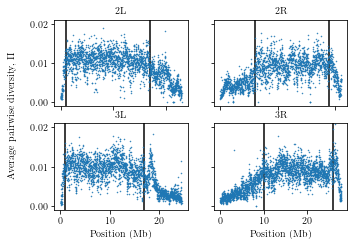

In [14]:
window_size = 10000

fig = plt.figure(figsize=(1.5*single_col_width, single_col_width))
for i, chrom in enumerate(chromosomes):
    n_w = chrom_lengths[chrom] // window_size
    pos = np.arange(n_w)*window_size / 1e6
    
    hascov = nobs[chrom] > 0
    hascov_w = np.sum(hascov[:n_w*window_size].reshape(n_w, window_size), axis=1)

    
    pi = h.pairwise_diversity(mac[chrom], nobs[chrom])
    pi_w = np.nansum(pi[:n_w*window_size].reshape(n_w, window_size), axis=1)
                             
    ax = plt.subplot(2,2,i+1)
    ax.plot(pos, pi_w/hascov_w, '.', ms=1, alpha=1)#, linestyle='steps-pre')
    ax.vlines([start[chrom]/1e6,end[chrom]/1e6], -0.001, 0.021)
    
    ax.set_ylim([-0.001, 0.021])

    ax.set_title(chrom)
    if i%2 != 0:
        ax.set_yticklabels([])
    if i >= 2:
        ax.set_xlabel('Position (Mb)')
    else:
        ax.set_xticklabels([])
fig.text(0,0.5, r'Average pairwise diversity, $\Pi$', rotation=90, va='center')
# fig.savefig('../manuscript/figures/pi_vs_position.pdf')

# Called genotypes in the central regions

In [15]:
nobs_c = {c:nobs[c][start[c]:end[c]] for c in chromosomes}
mac_c = {c:mac[c][start[c]:end[c]] for c in chromosomes}

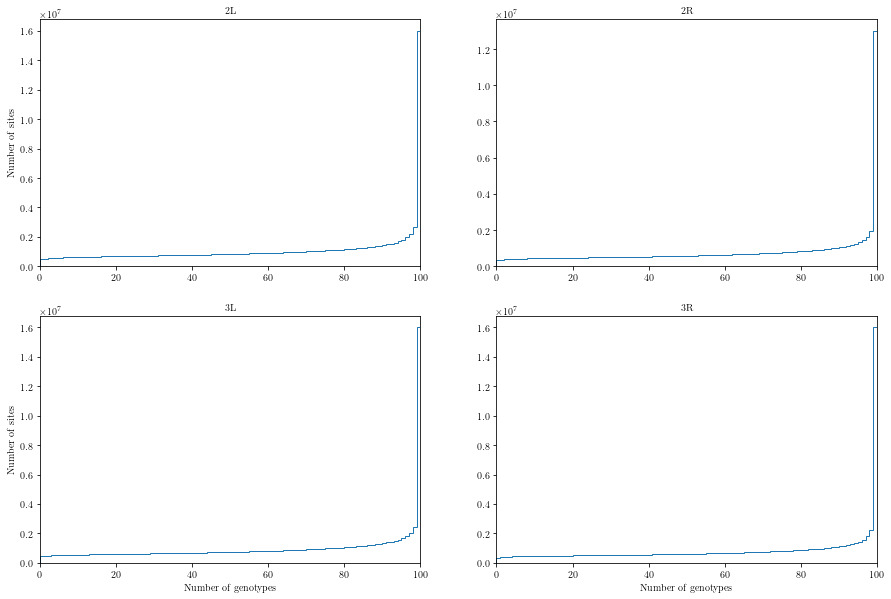

In [16]:
# Plot histograms of the number of alleles called at each site
plt.figure(figsize=(15,10))
for i, chrom in enumerate(chromosomes):
    plt.subplot(2,2,i+1)
    plt.hist(nobs_c[chrom], bins=np.arange(0,101,1), cumulative=True, histtype='step')
    plt.xlim([0,100])
    plt.title(chrom)
    if i%2 == 0:
        plt.ylabel('Number of sites')
    if i >= 2:
        plt.xlabel('Number of genotypes')
plt.show()

In [17]:
# Set the coverage cutoff at 90/100 genotypes called
cov_cutoff = 90
print('Fraction of sites with >= 90 genotypes')
print('Chrom.\tAll\tPolymorphic')
for c in chromosomes:
    f_suf = np.mean(nobs_c[c] >= cov_cutoff)
    f_seg_suf = np.sum((nobs_c[c] >= cov_cutoff) & (mac_c[c]>0)) / np.sum(mac_c[c]>0)
    print('{}\t{:.3f}\t{:.3f}'.format(c, f_suf, f_seg_suf))

Fraction of sites with >= 90 genotypes
Chrom.	All	Polymorphic
2L	0.913	0.924
2R	0.922	0.925
3L	0.919	0.920
3R	0.933	0.936


In [18]:
# Get the positions of sites with at least 90 genotypes called
sufficient_cov = {c:(nobs_c[c] >= cov_cutoff) for c in chromosomes}

# Diversity data

In [19]:
# Get number of genotypes (nobs), minor allele count (mac), minor allele frequency (maf),
# and pairwise diversity (pi) at sites with at least 90 called genotypes
nobs_suf = {}
mac_suf = {}
maf = {}
pi = {}
for c in chromosomes:
    n = np.zeros_like(nobs_c[c])
    n[sufficient_cov[c]] = nobs_c[c][sufficient_cov[c]]
    nobs_suf[c] = n
    
    m = np.zeros_like(mac_c[c])
    m[sufficient_cov[c]] = mac_c[c][sufficient_cov[c]]
    mac_suf[c] = m
    
    f = m/n
    f[np.isnan(f)] = 0
    maf[c] = f
    
    p = h.pairwise_diversity(m,n)
    p[np.isnan(p)] = 0
    pi[c] = p

/Users/danielrice/miniconda3/envs/multiplemergers/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/Users/danielrice/repos/multiplemergers/src/helpers.py:11: RuntimeWarning: invalid value encountered in true_divide
  f = allele_counts / sample_size
/Users/danielrice/repos/multiplemergers/src/helpers.py:12: RuntimeWarning: divide by zero encountered in true_divide
  return 2*f*(1-f) / (1 - (1/sample_size))


In [20]:
for c in chromosomes:
    print('{}\t{:.4f}\t{:.3f}'.format(c,
                                      np.sum(pi[c])/np.sum(sufficient_cov[c]),
                                      np.sum(mac_suf[c]>0)/np.sum(sufficient_cov[c])))

2L	0.0101	0.088
2R	0.0091	0.076
3L	0.0092	0.070
3R	0.0086	0.075


In [21]:
# Get number of genotypes (nobs), minor allele count (mac), minor allele frequency (maf),
# and pairwise diversity (pi) at 4-fold degenerate sites with at least 90 called genotypes

sufcov4d = {}
nobs4d = {}
mac4d = {}
maf4d = {}
pi4d = {}
for c in chromosomes:
    # Adjust the positions
    pos4d = fourD_pos[c][(fourD_pos[c]>start[c]) & (fourD_pos[c]<end[c])] - start[c]
    is4d = np.zeros_like(sufficient_cov[c])
    is4d[pos4d] = True
    print(np.mean(is4d))
    
    # This holds boolean values: True for sufficient coverage and 4d
    s = np.zeros_like(sufficient_cov[c])
    s[is4d] = sufficient_cov[c][is4d]
    sufcov4d[c] = s.astype(int)
    
    n = np.zeros_like(nobs_c[c])
    n[s] = nobs_c[c][s]
    nobs4d[c] = n
    
    m = np.zeros_like(mac_c[c])
    m[s] = mac_c[c][s]
    mac4d[c] = m
    
    f = m/n
    f[np.isnan(f)] = 0
    maf4d[c] = f
    
    p = h.pairwise_diversity(m,n)
    p[np.isnan(p)] = 0
    pi4d[c] = p

0.03022025


/Users/danielrice/miniconda3/envs/multiplemergers/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


0.033806076923076925
0.0304045625
0.03126825


In [27]:
# Calculate the critical distance using D. melanogaster measurements
mu_dmel = 3e-9
r_dmel = 2e-8
pi_dmel = np.mean([pi_mean[chrom] for chrom in chromosomes])
d_crit = 2*mu_dmel / (r_dmel*pi_dmel)
print(d_crit)

14.720352836341634


In [48]:
lag_max = int(10*d_crit)

In [49]:
# Number of valid comparisons (i.e. pairs of 4-fold degenerate sites with at least 90 genotypes) at a function of distance.
comparisons4d = {}
for c in chromosomes:
    comparisons4d[c] = np.correlate(sufcov4d[c], sufcov4d[c][:-lag_max])

In [50]:
pi_mean = {c: np.sum(pi4d[c])/np.sum(sufcov4d[c])
           for c in chromosomes}
print(pi_mean)

{'2L': 0.022934785130634457, '2R': 0.020445331568658166, '3L': 0.01989982930917762, '3R': 0.018239839104114676}


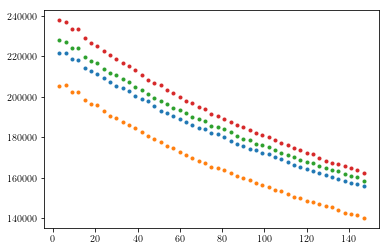

In [51]:
for c in chromosomes:
    plt.plot(np.arange(3, lag_max+1, 3), comparisons4d[c][3:lag_max+1:3], '.')

In [52]:
seg4d = {c: (mac4d[c]>0).astype(int) for c in chromosomes}
seg_corr4d = {c: np.correlate(seg4d[c], seg4d[c][:-lag_max]) for c in chromosomes}

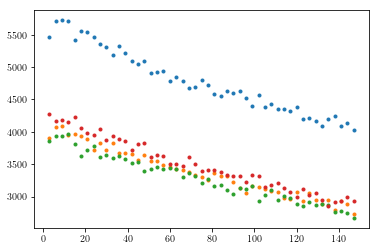

In [53]:
for c in chromosomes:
    plt.plot(np.arange(3, lag_max+1, 3), seg_corr4d[c][3:lag_max+1:3], '.')

In [72]:
print(len(seg_corr4d['2L']))
print(lag_max)
print(n_samples//2)

148
147
50


In [86]:
np.save("two_sfs_2L.npy", two_sfs)

In [130]:
two_sfs_dict = {}
for c in chromosomes:
    print(c)
    two_sfs_dict[c] = np.zeros((n_samples//2 + 1, n_samples//2 + 1, len(seg_corr4d[c])))

    for i in range(1, n_samples//2 + 1):
        print(i)
        freq_i = (mac4d[c]==i).astype(int)
        for j in range(1, n_samples//2 + 1):
            freq_j = (mac4d[c]==j).astype(int)
            two_sfs_dict[c][i,j] = np.correlate(freq_i, freq_j[:-lag_max])
            
np.savez("two_sfs_dmel.npz", **two_sfs_dict)

2L
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
2R
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
3L
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
3R
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [132]:
# Check that all sites are accounted for
for c in chromosomes:
    print(c, np.allclose(np.sum(two_sfs_dict[c], axis=(0,1)), seg_corr4d[c]))

2L True
2R True
3L True
3R True


In [93]:
from matplotlib import colors

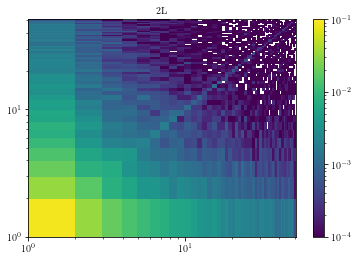

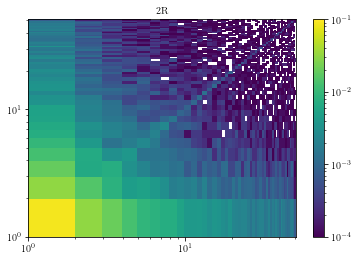

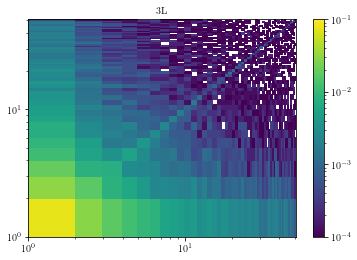

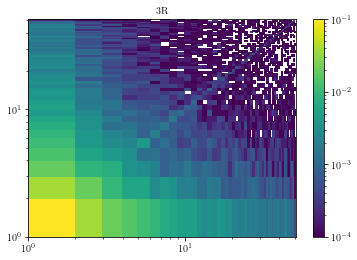

In [134]:
x = np.arange(0,n_samples//2+2)
d_start = 1
d_end = 15
for c in chromosomes:
    y = np.sum(two_sfs_dict[c][:,:,d_start:d_end], axis=-1)/np.sum(seg_corr4d[c][d_start:d_end])
    plt.pcolormesh(x, x, y,
                   norm=colors.LogNorm(vmin=0.0001, vmax=.1))
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim([1,51])
    plt.xlim([1,51])
    plt.colorbar()
    plt.title(c)
    plt.show()

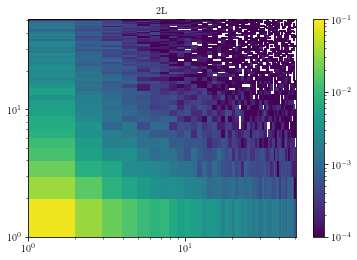

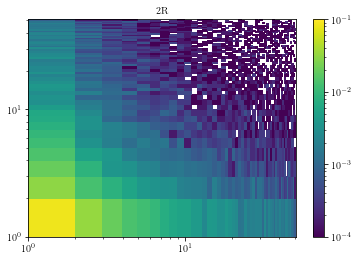

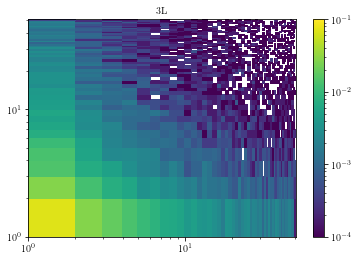

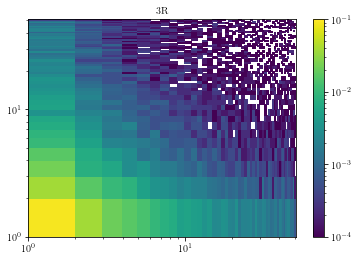

In [135]:
x = np.arange(0,n_samples//2+2)
d_start = -15
d_end = -1
for c in chromosomes:
    y = np.sum(two_sfs_dict[c][:,:,d_start:d_end], axis=-1)/np.sum(seg_corr4d[c][d_start:d_end])
    plt.pcolormesh(x, x, y,
                   norm=colors.LogNorm(vmin=0.0001, vmax=.1))
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim([1,51])
    plt.xlim([1,51])
    plt.colorbar()
    plt.title(c)
    plt.show()

5.010109837571984


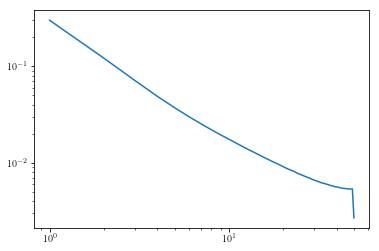

In [146]:
# Get the recombination distances and hi-lo correlations for msprime simulations of fastNeutrino-fitted models

cutoff = 5
r_list = np.insert(np.logspace(-1,3,13), 0, 0.0)
filename_fn = '../simulations/msprime/jsfs_fastNeutrino_n-{}_Chr{}_3EpochConstConst_r-{}.txt'
files_fn = {c: [filename_fn.format(n_samples,c,r) for r in r_list] for c in chromosomes}
data_fn = {c: h.import_msprime_corr(files_fn[c], n_samples) for c in chromosomes}
# print(data_fn['2L'])
sfs_fn = {c: np.mean(data_fn[c][1], axis=0) for c in chromosomes}

plt.loglog(np.arange(1,51), sfs_fn['2L']/np.sum(sfs_fn['2L']))
print(np.sum(sfs_fn['2L']))
# d_fn = {c : r_list * data_fn[c][0] /2 for c in chromosomes}
# hlc_fn = {c:data_fn[c][5][:,cutoff-1] for c in chromosomes}

# plt.show()
# for c in chromosomes:
#     plt.semilogx(d_fn[c], hlc_fn[c])

In [154]:
d_fn = {c : r_list * data_fn[c][0] /2 for c in chromosomes}
print(d_fn)

{'2L': array([0.00000000e+00, 3.78787477e-02, 8.16495415e-02, 1.75580777e-01,
       3.78410791e-01, 8.14598618e-01, 1.75355122e+00, 3.78684123e+00,
       8.14717908e+00, 1.75716874e+01, 3.78942183e+01, 8.15444226e+01,
       1.75605707e+02, 3.78647464e+02]), '2R': array([0.00000000e+00, 3.58517610e-02, 7.71115419e-02, 1.66444790e-01,
       3.58953785e-01, 7.73922925e-01, 1.66597360e+00, 3.58707329e+00,
       7.73136342e+00, 1.66784411e+01, 3.58737611e+01, 7.72403850e+01,
       1.66417348e+02, 3.59203123e+02]), '3L': array([0.00000000e+00, 4.34397111e-02, 9.36575185e-02, 2.01906206e-01,
       4.35400970e-01, 9.37997633e-01, 2.02073856e+00, 4.35623217e+00,
       9.37759534e+00, 2.02055373e+01, 4.35096656e+01, 9.36965898e+01,
       2.01872996e+02, 4.35558144e+02]), '3R': array([0.00000000e+00, 3.50012069e-02, 7.51660438e-02, 1.62419725e-01,
       3.49709032e-01, 7.52605864e-01, 1.62483031e+00, 3.49550606e+00,
       7.52039052e+00, 1.62473431e+01, 3.50026635e+01, 7.52416957e+01,


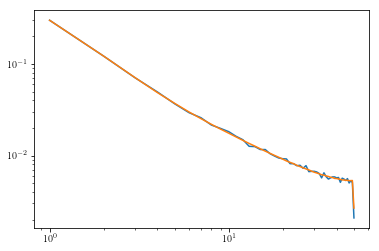

In [153]:
sfs_2L = np.histogram(mac4d['2L'], bins=np.arange(52))[0][1:]
plt.loglog(np.arange(1,51), sfs_2L/np.sum(sfs_2L))
plt.loglog(np.arange(1,51), sfs_fn['2L']/np.sum(sfs_fn['2L']))



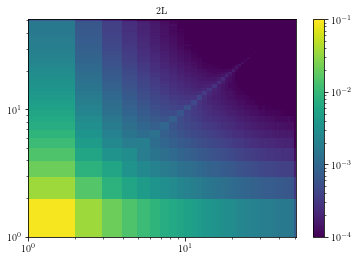

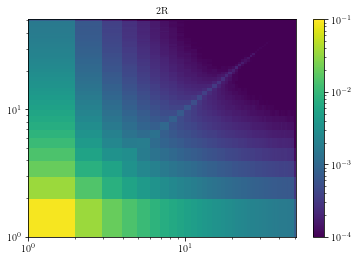

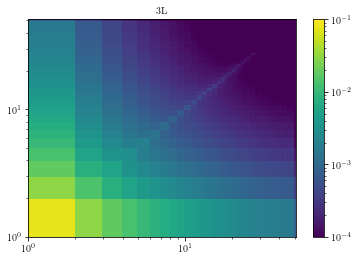

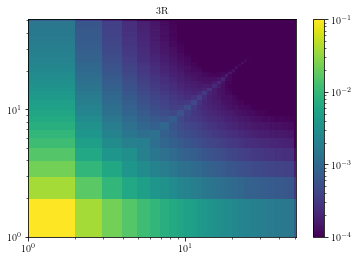

In [162]:
d_index=5
two_sfs_fn = {c: data_fn[c][2][d_index] for c in chromosomes}

for c in chromosomes:
    x = np.arange(1,n_samples//2+2)
    y = two_sfs_fn[c]/np.sum(two_sfs_fn[c])
    plt.pcolormesh(x, x, y,
                   norm=colors.LogNorm(vmin=0.0001, vmax=.1))
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim([1,51])
    plt.xlim([1,51])
    plt.colorbar()
    plt.title(c)
    plt.show()

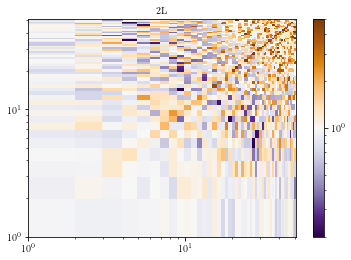

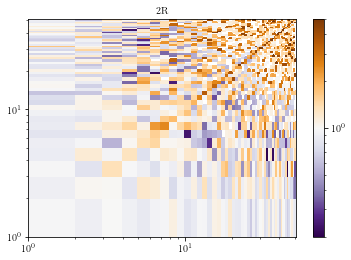

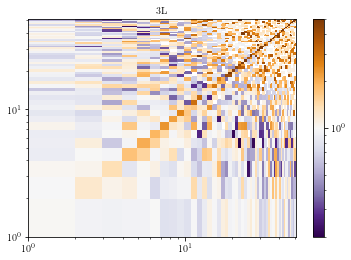

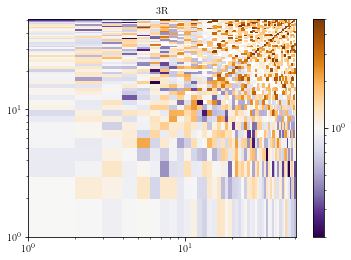

In [187]:
d_index=5
two_sfs_fn = {c: data_fn[c][2][d_index] for c in chromosomes}


d_start = 1
d_end = 15

factor = 5
for c in chromosomes:
    x = np.arange(1,n_samples//2+2)
    
    num = np.sum(two_sfs_dict[c][1:,1:,d_start:d_end], axis=-1)/np.sum(seg_corr4d[c][d_start:d_end])
    den = two_sfs_fn[c]/np.sum(two_sfs_fn[c])
    plt.pcolormesh(x, x, num/den,
                   norm=colors.LogNorm(vmin=1.0/factor, vmax=factor),
                   cmap='PuOr_r')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim([1,51])
    plt.xlim([1,51])
    plt.colorbar()
    plt.title(c)
    plt.show()

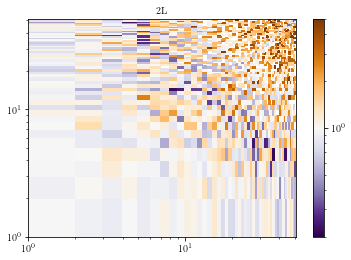

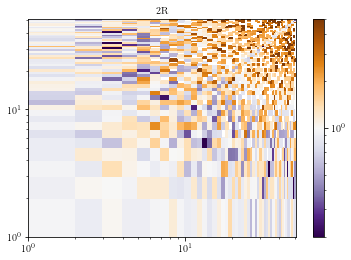

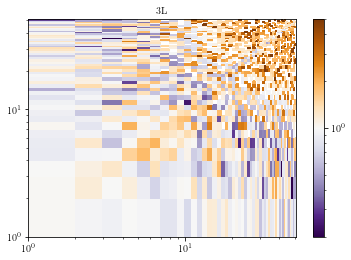

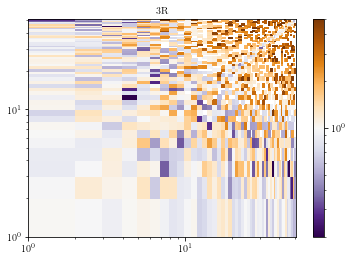

In [195]:
d_index=3
two_sfs_fn = {c: data_fn[c][2][d_index] for c in chromosomes}

d_start = 1
d_end = 10

factor = 5
for c in chromosomes:
    x = np.arange(1,n_samples//2+2)
    
    num = np.sum(two_sfs_dict[c][1:,1:,d_start:d_end], axis=-1)/np.sum(seg_corr4d[c][d_start:d_end])
    den = two_sfs_fn[c]/np.sum(two_sfs_fn[c])
    plt.pcolormesh(x, x, num/den,
                   norm=colors.LogNorm(vmin=1.0/factor, vmax=factor),
                   cmap='PuOr_r')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim([1,51])
    plt.xlim([1,51])
    plt.colorbar()
    plt.title(c)
    plt.show()

In [197]:
def lump_sfs(sfs, bmax):
    sfs_lumped = np.zeros(bmax+1)
    sfs_lumped[:bmax] = sfs[:bmax]
    sfs_lumped[bmax] = sum(sfs[bmax:])
    return(sfs_lumped)

def lump_2sfs(twosfs, bmax):
    lumped = np.zeros((bmax+1, bmax+1))
    lumped[:bmax,:bmax] = twosfs[:bmax,:bmax]
    lumped[bmax,:bmax] = np.sum(twosfs[bmax:,:bmax],axis=0)
    lumped[:bmax, bmax] = np.sum(twosfs[:bmax:, bmax:],axis=1)
    lumped[bmax, bmax] = np.sum(twosfs[bmax:,bmax:])
    return(lumped)

def kldiv(p, q):
    return - np.sum(p*np.log2(q/p))

D = 0.8197480777530767


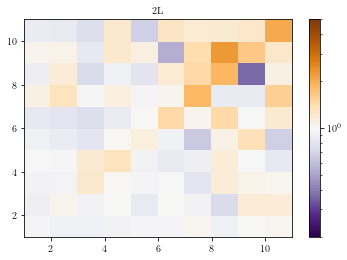

KLD: 0.009127479096426815
X^2: 318.66478627603516


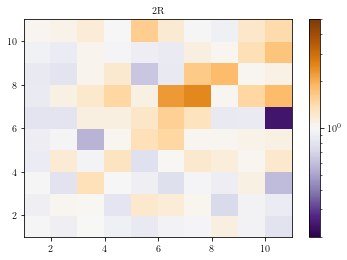

KLD: 0.013521991796322758
X^2: 338.1739419496556


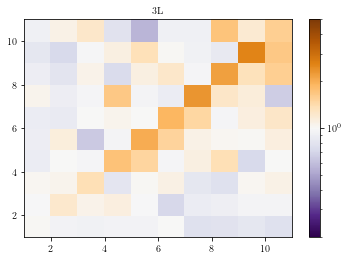

KLD: 0.013636164850119224
X^2: 369.1232931103005


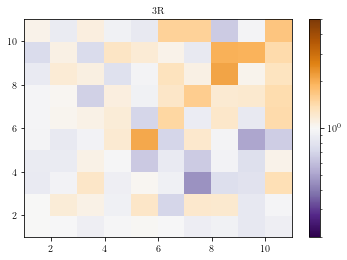

KLD: 0.010871647333075832
X^2: 277.4269284729307


In [216]:
d_start = 1
d_end = 15

for d_index in [5]: #range(10):
    print("D = {}".format(r_list[d_index] * np.mean([data_fn[c][0] for c in chromosomes]) /2))

    two_sfs_fn = {c: data_fn[c][2][d_index] for c in chromosomes}

    mac_cutoff = 10


    factor = 5
    for c in chromosomes:
        x = np.arange(1,mac_cutoff+2)

        num = np.sum(two_sfs_dict[c][1:,1:,d_start:d_end], axis=-1)/np.sum(seg_corr4d[c][d_start:d_end])
        num = lump_2sfs(num, mac_cutoff)
#         num = (num + num.T)/2
        den = two_sfs_fn[c]/np.sum(two_sfs_fn[c])
        den = lump_2sfs(den, mac_cutoff)
#         den = (den + den.T)/2

        plt.pcolormesh(x, x, num/den,
                       norm=colors.LogNorm(vmin=1.0/factor, vmax=factor),
                       cmap='PuOr_r')
        plt.colorbar()
        plt.title(c)
        plt.show()
        
        total = np.sum(seg_corr4d[c][d_start:d_end])
        expected = total*den
        observed = total*num
        
        print("KLD:", kldiv(den,num))
        print("X^2:", np.sum((expected-observed)**2 / expected))


/Users/danielrice/miniconda3/envs/multiplemergers/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log2
  # Remove the CWD from sys.path while we load stuff.
/Users/danielrice/miniconda3/envs/multiplemergers/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log2
  del sys.path[0]


0.031486192241893265


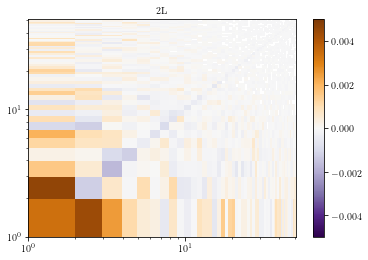

0.028015433276859715


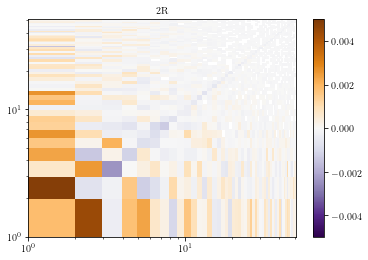

0.03471856026324876


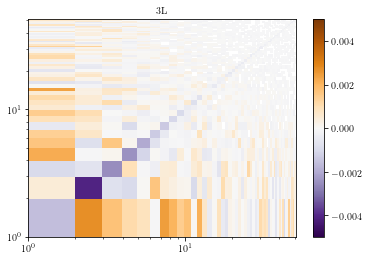

0.022519501727523365


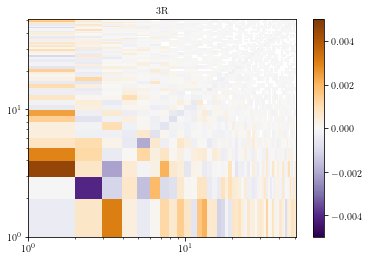

In [183]:
d_start = 1
d_end = 15

factor = 5
for c in chromosomes:
    x = np.arange(1,n_samples//2+2)
    
    num = np.sum(two_sfs_dict[c][1:,1:,d_start:d_end], axis=-1)/np.sum(seg_corr4d[c][d_start:d_end])
    den = two_sfs_fn[c]/np.sum(two_sfs_fn[c])
    plt.pcolormesh(x, x, -den*np.log2(num/den), vmin=-0.005, vmax=0.005,#)#,
                   #norm=colors.LogNorm(vmin=1.0/factor, vmax=factor),
                   cmap='PuOr_r')
    
    temp = np.log2(num/den)
    temp[np.isinf(temp)] = 0
    print(np.nansum(-den*temp))
    
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim([1,51])
    plt.xlim([1,51])
    plt.colorbar()
    plt.title(c)
    plt.show()

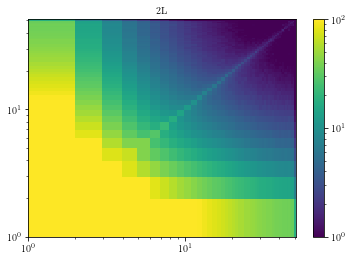

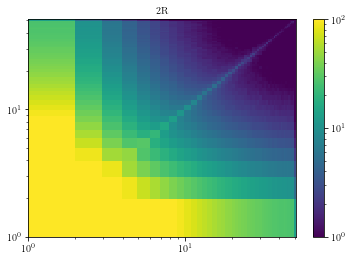

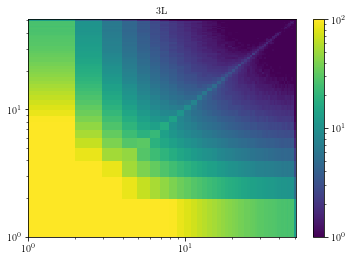

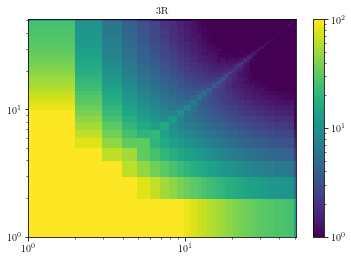

In [177]:
d_start = 1
d_end = 15

for c in chromosomes:
    x = np.arange(1,n_samples//2+2)
    
#     num = np.sum(two_sfs_dict[c][1:,1:,d_start:d_end], axis=-1)/np.sum(seg_corr4d[c][d_start:d_end])
    exp = np.sum(seg_corr4d[c][d_start:d_end]) * two_sfs_fn[c]/np.sum(two_sfs_fn[c])
    plt.pcolormesh(x, x, exp,
                   norm=colors.LogNorm(vmin=1.0, vmax=100.0))#,
#                    cmap='PuOr_r')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim([1,51])
    plt.xlim([1,51])
    plt.colorbar()
    plt.title(c)
    plt.show()

In [ ]:
two_sfs_fn[c]/np.sum(two_sfs_fn[c])



In [22]:
# Identify the high- and low- frequency mutations
freq_cutoff = 0.05
hi_freq4d = {c: ((mac4d[c]>0) & (maf4d[c] > freq_cutoff)).astype(int) for c in chromosomes}
lo_freq4d = {c: ((mac4d[c]>0) & (maf4d[c] <= freq_cutoff)).astype(int) for c in chromosomes}

In [23]:
# Calculate the number of high- and low- frequency mutations
f_hi4d = {c: np.sum(hi_freq4d[c]) / np.sum(sufcov4d[c]) for c in chromosomes}
f_lo4d = {c: np.sum(lo_freq4d[c]) / np.sum(sufcov4d[c]) for c in chromosomes}
print(f_lo4d, f_hi4d)

{'2R': 0.07498023531600242, '2L': 0.0871522086181951, '3R': 0.07551566637782331, '3L': 0.06628409529505075} {'2R': 0.05736641398874576, '2L': 0.06446442424618042, '3R': 0.05089851880046323, '3L': 0.05591607181483885}


In [24]:
# Calculate the correlation between high- and low-frequency mutations (related to hiloPMI)
hilo_corr4d = {c: np.correlate(hi_freq4d[c], lo_freq4d[c][:-lag_max]) for c in chromosomes}

# Comparison w/ `fastNeutrino`-fitted models

In [25]:
def wpmi(eta, eta2, n):
    '''Calculate weighted pointwise mutual information from folded SFS (eta) and 2-SFS (eta2)'''
    pi = h.sfs2pi(eta, n)
    ret = eta2 * np.log2(eta2 / np.outer(eta, eta)) / pi**2
    ret[np.diag_indices_from(ret)] = np.nan
    return ret

def wpmi_pcolor(ax, mac, wpmi, scale, vm, **kwargs):
    '''Plot heatmaps of weighted PMI on an arcsinh scale'''
    ax.set_xscale('log')
    ax.set_yscale('log')
    np.fill_diagonal(wpmi, np.nan)
    return ax.pcolormesh(mac, mac, np.arcsinh(wpmi/scale), vmin=-vm, vmax=vm, **kwargs)

def wpmi_colorbar(ax, scale, vm, cmap):
    '''Plot colorbar heatmaps of weighted PMI'''
    yticks = np.array([-15, -3, 0, 3, 15])
    yticks_transformed = 256 * (np.arcsinh(yticks) + vm)/(2*vm)
    ax.set_xticks([])
    ax.set_yticks(yticks_transformed)
    ax.set_yticklabels(yticks*scale)
    val = np.linspace(-vm, vm, 256)
    return ax.pcolormesh(val[:,None], cmap=cmap, vmin=-vm, vmax=vm)

cmap = 'PuOr_r'
n_sim = 100
mac_sim = np.arange(1, (n_sim+1)//2 + 1)

In [25]:
n_samples = 100

In [26]:
# Compute SFS from data
sfs_data = {c : np.histogram(mac4d[c], bins=np.arange(1,n_samples//2+2))[0] / np.sum(sufcov4d[c]) for c in chromosomes}

In [28]:
# Compute 2-SFS (jsfs=joint SFS, which I use synonymously)
jsfs_data = {}
dmax = 200

for c in chromosomes:
    jsfs = np.zeros((n_samples//2, n_samples//2))
    for i in range(len(mac4d[c]) - dmax):
        mac_i = mac4d[c][i]
        if mac_i > 0:
            hist = np.histogram(mac4d[c][i+1:i+dmax], bins=np.arange(1,n_samples//2+2))[0]
            jsfs[mac_i - 1] += hist
    jsfs_data[c] = jsfs / np.sum(comparisons4d[c][1:dmax])

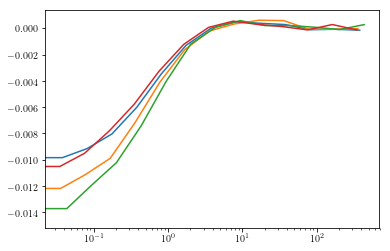

In [30]:
# Get the recombination distances and hi-lo correlations for msprime simulations of fastNeutrino-fitted models

cutoff = 5
r_list = np.insert(np.logspace(-1,3,13), 0, 0.0)
filename_fn = '../simulations/msprime/jsfs_fastNeutrino_n-{}_Chr{}_3EpochConstConst_r-{}.txt'
files_fn = {c: [filename_fn.format(n_samples,c,r) for r in r_list] for c in chromosomes}
data_fn = {c: h.import_msprime_corr(files_fn[c], n_samples) for c in chromosomes}

sfs_fn = {c: np.mean(data_fn[c][1], axis=0)/np.mean(data_fn[c][0]) for c in chromosomes}

d_fn = {c : r_list * data_fn[c][0] /2 for c in chromosomes}
hlc_fn = {c:data_fn[c][5][:,cutoff-1] for c in chromosomes}

plt.show()
for c in chromosomes:
    plt.semilogx(d_fn[c], hlc_fn[c])

In [28]:
# Get the recombination distances and hi-lo correlations for Kingman simulations
cutoff = 5

r_list_k = r_list[:-3]
head = '../simulations/msprime/jsfs_n-{}_'.format(n_samples)
files_k = [head + 'a-{}_r-{}.txt'.format(2.0, r) for r in r_list_k]

data_k = h.import_msprime_corr(files_k, n_samples)
sfs_k = np.mean(data_k[1], axis=0)/np.mean(data_k[0])

d_k = r_list_k * data_k[0] /2
hlc_k = data_k[5][:,cutoff-1]

NameError: name 'r_list' is not defined

In [34]:
from scipy import interpolate

/Users/dpr/miniconda3/envs/mmc/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.
/Users/dpr/miniconda3/envs/mmc/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


8.147179084692096
7.731363416263832
9.37759533653021
7.520390515712439


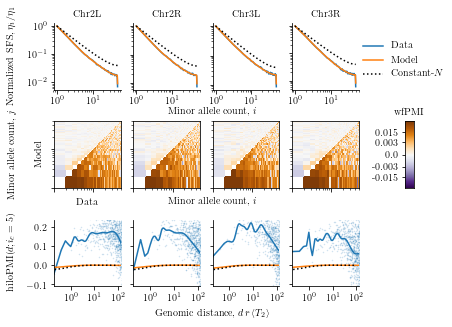

In [38]:
# Plot comparisons of data to fitted models.

# smoothing_factor = 2e-5
smoothing_factor = 4e-5
c_data = 'C0'
c_fn = 'C1'
c_k = 'k'
style_k = 'dotted'
vm_sim = 5
scale_sim = 1e-3

xscale = 1.75
yscale = 1.5
fig = plt.figure(figsize=(xscale*single_col_width, yscale*single_col_width))

x_text = 0.025 / xscale
x_panel = 0.12
x_cb = 0.9
panel_size = 0.265
panel_buffer = 0.05
panel_bottom = 0.1
panel_width = panel_size / xscale
panel_height = panel_size / yscale
panel_xbuffer = panel_buffer / xscale
panel_ybuffer = 2.5 * panel_buffer / yscale    

for i_c, c in enumerate(chromosomes):
    ax = fig.add_axes([x_panel + i_c*(panel_width+panel_xbuffer),
                      panel_bottom + 2*(panel_height+panel_ybuffer),
                      panel_width,
                      panel_height])
    x_sfs = np.arange(1, n_samples//2 + 1)
    ax.loglog(x_sfs, sfs_data[c] / sfs_data[c][0], c=c_data, label='Data')
    ax.loglog(x_sfs, sfs_fn[c] / sfs_fn[c][0], c=c_fn, label='Model')
    ax.loglog(x_sfs, ((1/x_sfs) + (1/(n_samples-x_sfs)))/ (1 + 1/(n_samples-1)), c_k, linestyle=style_k, label='Constant-$N$')
    if i_c == 3:
        ax.legend(loc=(1,0.1), frameon=False)
    if i_c != 0:
        ax.set_yticklabels([])
    ax.set_title("Chr"+c)   
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax = fig.add_axes([x_panel + i_c*(panel_width+panel_xbuffer),
                  panel_bottom + 1*(panel_height+panel_ybuffer),
                  panel_width,
                  panel_height])
    w_data = wpmi(sfs_data[c], jsfs_data[c], n_sim)
    w_data[np.tril_indices_from(w_data)] = 0
    # Chosen to match the typical recombination rate in the data.
    i_0 = 8
    print(d_fn[c][i_0])
    w_sim = wpmi(data_fn[c][1][i_0], data_fn[c][2][i_0], n_sim)
    w_sim[np.triu_indices_from(w_sim)] = 0
    w_tot = w_data + w_sim
    wpmi_pcolor(ax, mac_sim, w_tot, scale_sim, vm_sim, cmap=cmap)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    if i_c == 0:
        # ax.set_ylabel('Minor allele count, $j$')
        ax.set_ylabel('Model')
        ax.set_xlabel('Data')
    ax = fig.add_axes([x_panel + i_c*(panel_width+panel_xbuffer),
                  panel_bottom,
                  panel_width,
                  panel_height])
    x = np.arange(3,lag_max,3)
    y = np.log2(hilo_corr4d[c][3::3]/comparisons4d[c][3::3]/(f_lo4d[c]*f_hi4d[c]))

    x = x[:len(x)]
    y = y[:len(y)]
    # Smooth on a log x-scale. Use adaptive weights
    x_sm = np.log(x)
    w = 1/x
    yinterp = interpolate.UnivariateSpline(x_sm, y, w, s=smoothing_factor)(x_sm)
    ax.semilogx(x/d_crit, y, '.', alpha=0.2, c=c_data, ms=1)
    ax.semilogx(x/d_crit, yinterp, c=c_data)
    ax.semilogx(d_fn[c], np.log2(hlc_fn[c]+1), c=c_fn)
    ax.semilogx(d_k, np.log2(hlc_k+1), c=c_k, linestyle=style_k)
    if i_c != 0:
        ax.set_yticklabels([])
    plt.ylim([-0.11,0.24])
    plt.xlim([2e-1, (1/8)*1e3])
    ax.set_xticks([1,10,100])
    ax.set_yticks([-0.1,0,0.1,0.2])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


ax = fig.add_axes([x_panel + 4*(panel_width+panel_xbuffer)+ panel_width/2,
                  panel_bottom + panel_height + panel_ybuffer,
                  0.02,
                  panel_height])
wpmi_colorbar(ax, scale_sim, vm_sim, cmap=cmap)
ax.set_title('wfPMI')

fig.text(x_text,
         panel_bottom + panel_height/2 + 2*(panel_height + panel_ybuffer),
         'Normalized SFS, $\eta_i / \eta_1$',
         va='center', rotation=90)
fig.text(x_text,
          panel_bottom + panel_height/2 + 1*(panel_height + panel_ybuffer),
          'Minor allele count, $j$',
          va='center', rotation=90)
fig.text(x_text,
         panel_bottom + panel_height/2,
         'hiloPMI$(d;i_c=5)$',
         va='center', rotation=90)

fig.text(x_panel + 2*(panel_width+panel_xbuffer),
         panel_bottom + 2*panel_height + 1.25*panel_ybuffer,
         'Minor allele count, $i$', ha='center')
fig.text(x_panel + 2*(panel_width+panel_xbuffer),
         panel_bottom + panel_height + panel_ybuffer/2,
         'Minor allele count, $i$', ha='center')

fig.text(x_panel + 2*(panel_width+panel_xbuffer),
         panel_bottom - panel_ybuffer,
         r'Genomic distance, $d\,r \left<T_2\right>$', ha='center')
fig.savefig('../manuscript/figures/dpgp3_analysis.pdf')


1


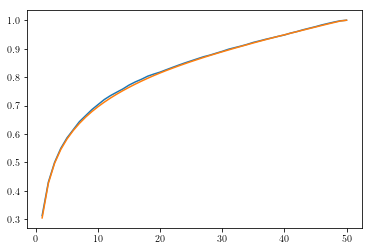

2


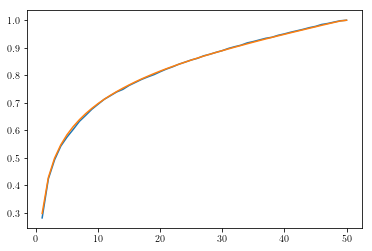

3


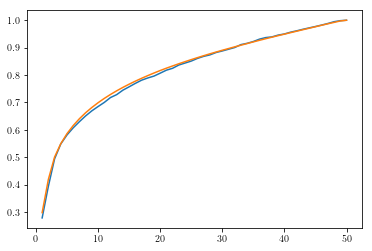

4


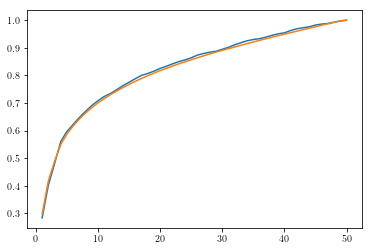

5


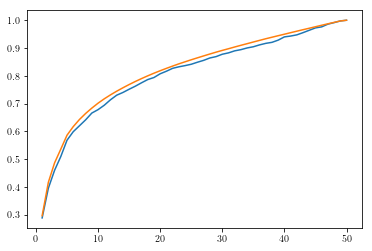

6


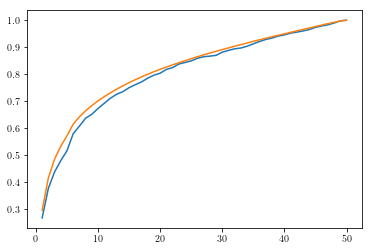

7


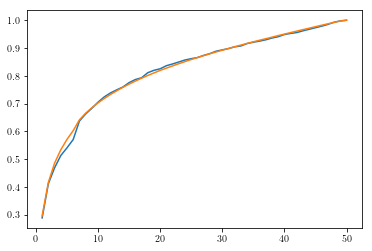

8


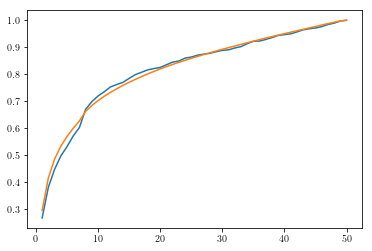

9


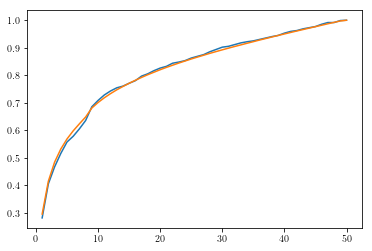

10


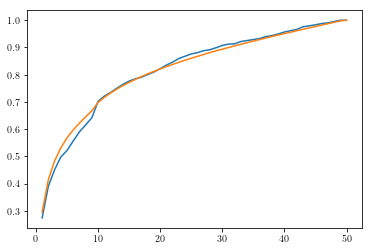

11


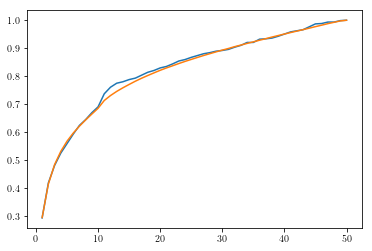

12


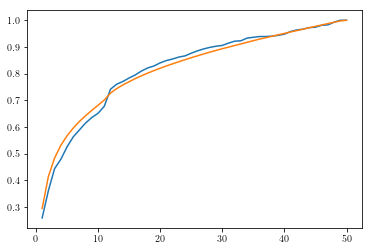

13


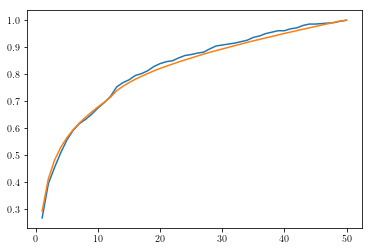

14


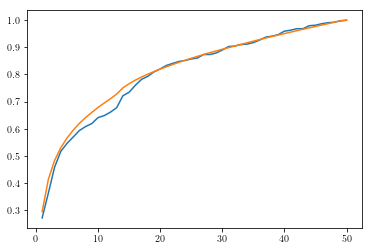

15


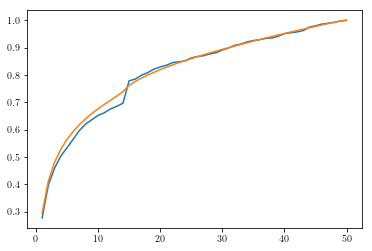

16


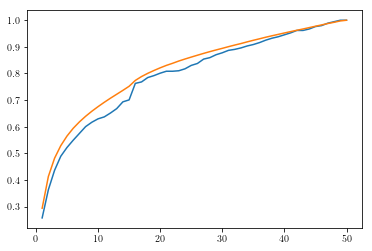

17


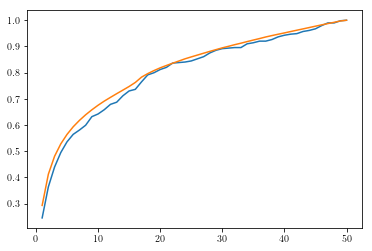

18


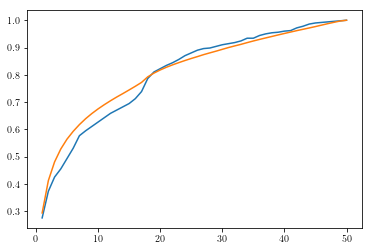

19


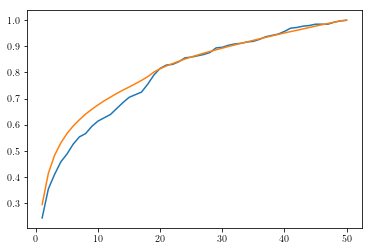

20


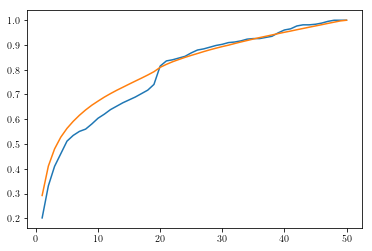

21


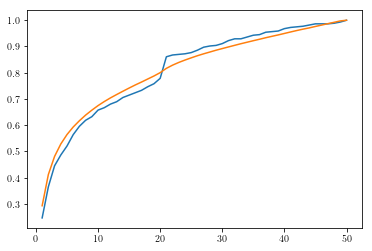

22


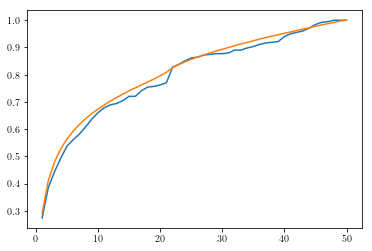

23


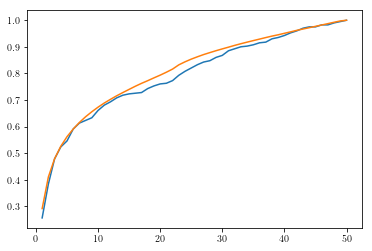

24


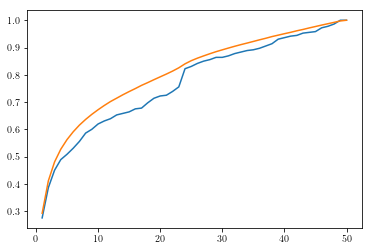

25


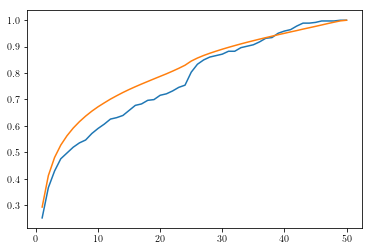

26


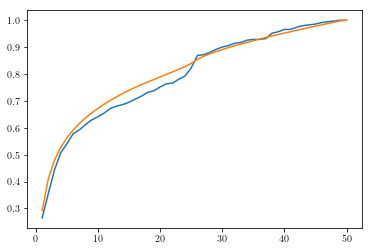

27


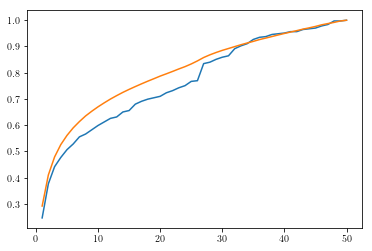

28


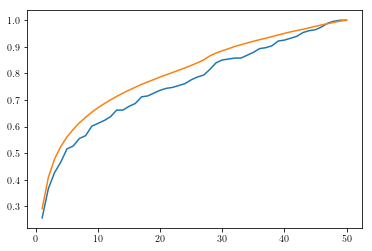

29


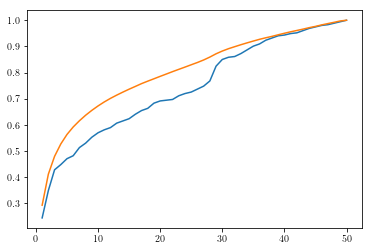

30


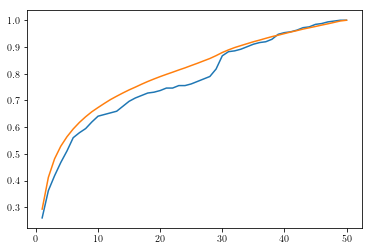

31


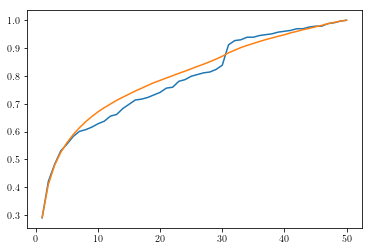

32


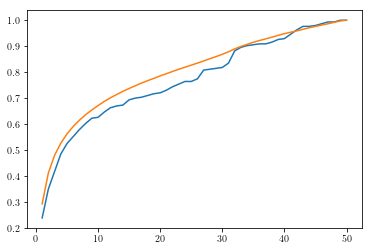

33


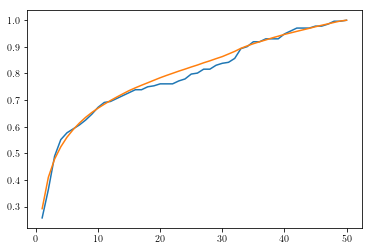

34


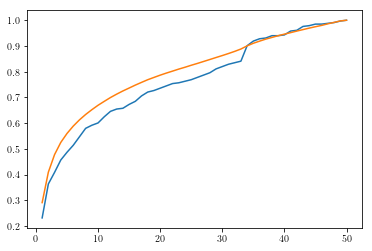

35


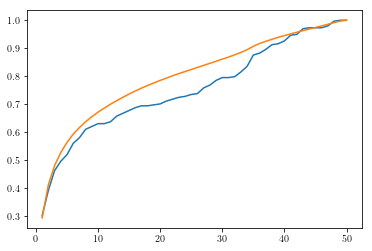

36


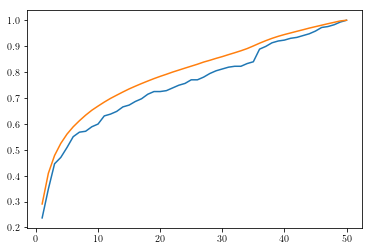

37


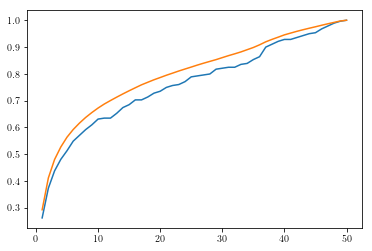

38


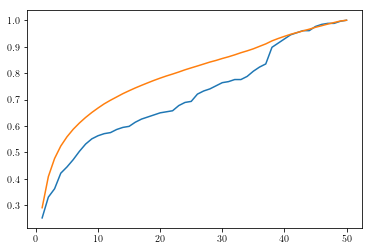

39


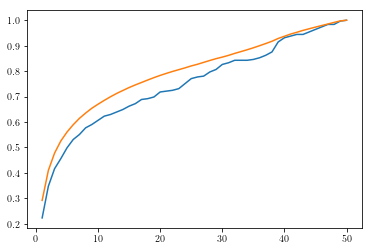

40


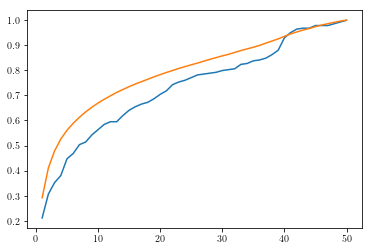

41


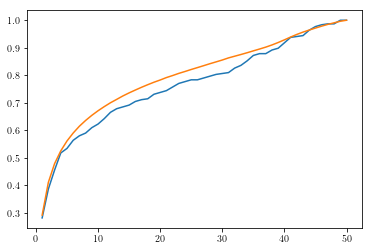

42


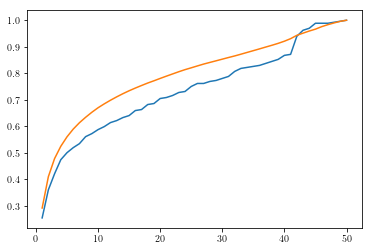

43


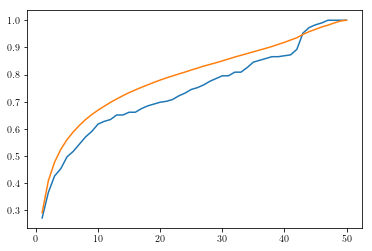

44


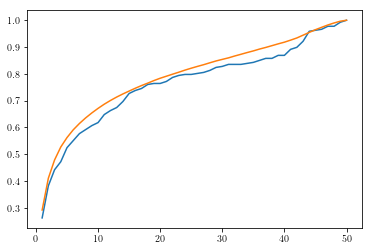

45


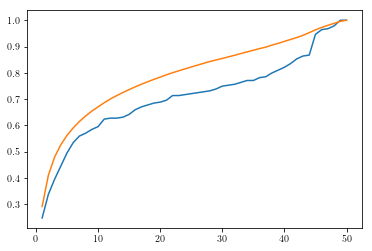

46


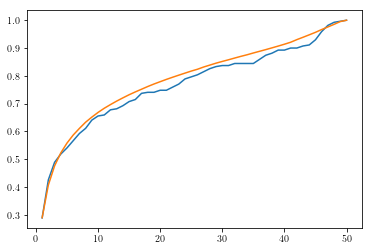

47


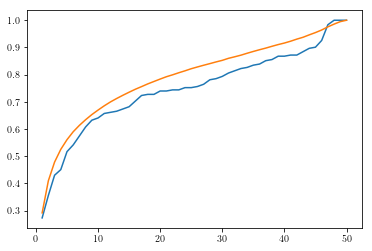

48


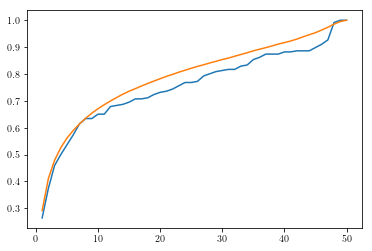

49


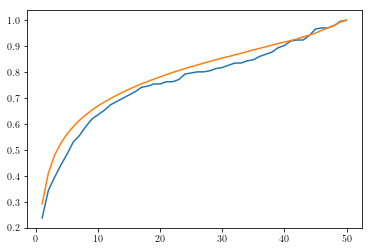

50


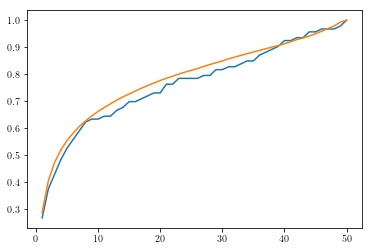

In [486]:
c = "2L"

# Sum over a range of distances and symmetrize
d_start = 1
d_end = 15
twosfs_empirical = np.sum(two_sfs_dict[c][1:,1:,d_start:d_end], axis=-1)
twosfs_empirical += twosfs_empirical.T
twosfs_empirical /= 2

d_index = 5
two_sfs_fn = data_fn[c][2][d_index]
twosfs_kingman = two_sfs_fn/np.sum(two_sfs_fn)


cumcounts_obs = np.cumsum(twosfs_empirical, axis=1)
n_obs = cumcounts_obs[:,-1]

F_obs = cumcounts_obs/n_obs[:,None]
F_exp = np.cumsum(twosfs_kingman, axis=1)
F_exp /= F_exp[:,-1][:,None]

for i in range(50):
    print(i+1)
    x = np.arange(1,n_samples//2+1)
    plt.plot(x, F_obs[i])
    plt.plot(x, F_exp[i])
    plt.show()

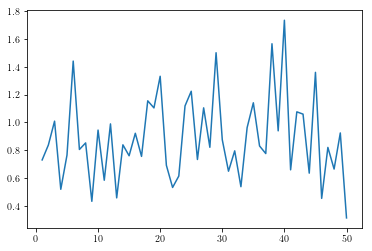

In [487]:
D = np.max(np.abs(F_obs - F_exp), axis=1) * np.sqrt(n_obs)
plt.plot(x, D)

In [488]:
n_obs_tot = np.sum(n_obs)
n_reps = 10000
D_r = np.zeros((n_reps, twosfs_kingman.shape[0]))
for rep in range(n_reps):
    rand_counts = np.random.multinomial(n_obs_tot, twosfs_kingman.ravel()).reshape(twosfs_kingman.shape)
    rand_counts = (rand_counts + rand_counts.T) / 2

    cumcounts_obs_r = np.cumsum(rand_counts, axis=1)
    n_obs_r = cumcounts_obs_r[:,-1]
    F_obs_r = cumcounts_obs_r/n_obs_r[:,None]
    
    D_r[rep] = np.max(np.abs(F_obs_r - F_exp), axis=1) * np.sqrt(n_obs_r)


Text(0, 0.5, 'KS statistic, $D$')

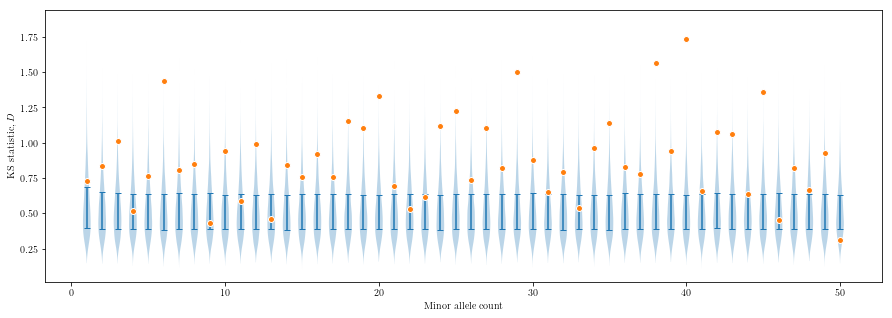

In [489]:
fig = plt.figure(figsize=(15,5))
plt.violinplot(D_r, showextrema=False)
plt.plot(x, np.percentile(D_r, 25, axis=0), linestyle='', marker='_', color='C0')
# plt.plot(x, np.percentile(D_r, 50, axis=0), linestyle='', marker='_', color='C0')
plt.plot(x, np.percentile(D_r, 75, axis=0), linestyle='', marker='_', color='C0')
plt.vlines(x, np.percentile(D_r, 25, axis=0), np.percentile(D_r, 75, axis=0), color='C0')
plt.plot(x, D, 'o', mec='w', mfc='C1')
plt.xlabel("Minor allele count")
plt.ylabel("KS statistic, $D$")

Text(0, 0.5, 'Number of counts')

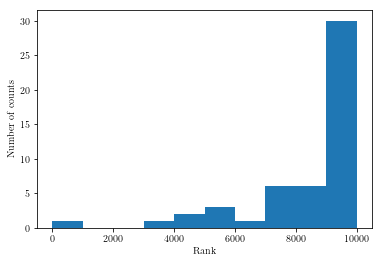

In [490]:
ranks = np.sum(D_r <= D[None,:], axis=0)
plt.hist(ranks, bins=np.linspace(0,n_reps,11))
plt.xlabel("Rank")
plt.ylabel("Number of counts")

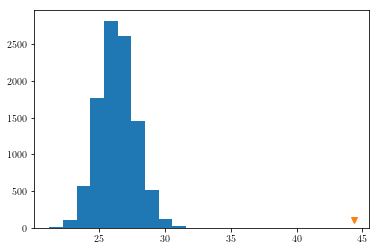

In [498]:
sum_obs = np.sum(D)
sum_sim = np.sum(D_r, axis=1)
plt.hist(sum_sim)
plt.plot(sum_obs, 100, 'v')

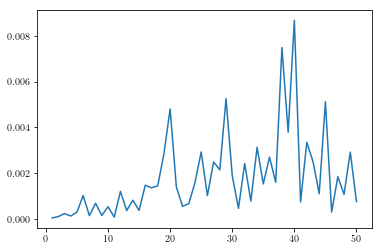

In [491]:
p_exp = twosfs_kingman / np.sum(twosfs_kingman,axis=1)[:,None]
D_cvm = np.sum((F_obs - F_exp)**2 * p_exp, axis=1) #* np.sqrt(n_obs)
plt.plot(x, D_cvm)

In [520]:
n_obs_tot = np.sum(n_obs)
n_reps = 10000
D_cvm_r = np.zeros((n_reps, twosfs_kingman.shape[0]))
for rep in range(n_reps):
    rand_counts = np.random.multinomial(n_obs_tot, twosfs_kingman.ravel()).reshape(twosfs_kingman.shape)
    rand_counts = (rand_counts + rand_counts.T) / 2

    cumcounts_obs_r = np.cumsum(rand_counts, axis=1)
    n_obs_r = cumcounts_obs_r[:,-1]
    F_obs_r = cumcounts_obs_r/n_obs_r[:,None]
    
    D_cvm_r[rep] = np.sum((F_obs_r - F_exp)**2 * p_exp, axis=1) * np.sqrt(n_obs_r)

Text(0, 0.5, 'Number of counts')

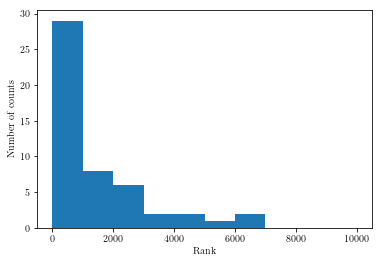

In [522]:
ranks = np.sum(D_cvm_r <= D_cvm[None,:], axis=0)
plt.hist(ranks, bins=np.linspace(0,n_reps,11))
plt.xlabel("Rank")
plt.ylabel("Number of counts")

In [451]:
def readsim(fn):
    times = None
    sizes = None
    with open(fn) as infile:
        while True:
            line = infile.readline()
            if not line.startswith("#"):
                break
            elif line.startswith("#DEMOCHANGE_TIMES"):
                times = np.array(line.split("=")[1].split(','), dtype=float)
            elif line.startswith("#DEMOCHANGE_SIZES"):
                sizes = np.array(line.split("=")[1].split(','), dtype=float)
#             print(line.strip())

        sfs = np.array(line.split(), dtype=float)
        twosfs = np.zeros((len(sfs), len(sfs)))
        twosfs[np.triu_indices_from(twosfs)] = np.array(infile.readline().split(), dtype=float)
        
    twosfs[np.diag_indices_from(twosfs)] /= 2
    twosfs += np.transpose(twosfs)
    
    # print(h.sfs2pi((sfs + sfs[::-1])[:50], 100))
    sfs /= np.sum(sfs)
    twosfs /= np.sum(twosfs)
    return sfs, twosfs, times, sizes

In [452]:
def fold_twosfs(twosfs):
    n_samples = twosfs.shape[0] + 1
    folded = (twosfs + twosfs[::-1,:] + twosfs[:,::-1] + twosfs[::-1,::-1])[:n_samples//2, :n_samples//2]
    if n_samples % 2 == 0:
        folded[:,-1] /= 2
        folded[-1,:] /= 2
    return folded

In [470]:
RS = np.insert(np.logspace(-1, 3, 13), 0, 0.0)
print(RS)

[0.00000000e+00 1.00000000e-01 2.15443469e-01 4.64158883e-01
 1.00000000e+00 2.15443469e+00 4.64158883e+00 1.00000000e+01
 2.15443469e+01 4.64158883e+01 1.00000000e+02 2.15443469e+02
 4.64158883e+02 1.00000000e+03]


In [551]:
n = 100
alpha = 1.5
model = "4EpochConst"

r_xibeta = "4.6415888336127775"
r_kingman = "3.0"

xibeta_fn = "../simulations/msprime/jsfs_n-{}_xibeta-{}_r-{}.txt".format(n, alpha, r_xibeta)
kingman_fn = "../simulations/msprime/jsfs_fastNeutrino-xibeta_n-{}_alpha-{}_{}_r-{}.txt".format(n,alpha,model,r_kingman)

sfs_xibeta, twosfs_xibeta, _, _ = readsim(xibeta_fn)
print(h.sfs2pi((sfs_xibeta + sfs_xibeta[::-1])[:n//2],n))
twosfs_xibeta /= np.sum(twosfs_xibeta)
twosfs_xibeta = fold_twosfs(twosfs_xibeta)

sfs_kingman, twosfs_kingman, times, sizes = readsim(kingman_fn)
print(h.sfs2pi((sfs_kingman + sfs_kingman[::-1])[:n//2],n))
twosfs_kingman /= np.sum(twosfs_kingman)
twosfs_kingman = fold_twosfs(twosfs_kingman)

# Check normalization
print(np.sum(twosfs_xibeta))
print(np.sum(twosfs_kingman))


0.24089182304296813
0.23701347981887957
1.0
1.0


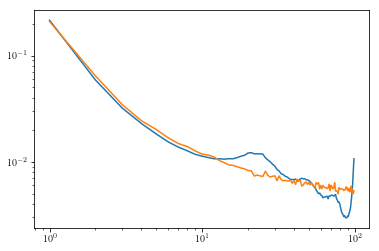

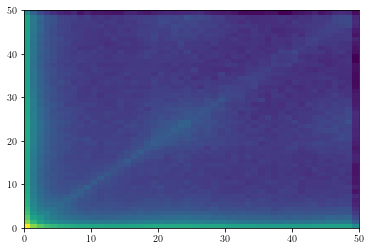

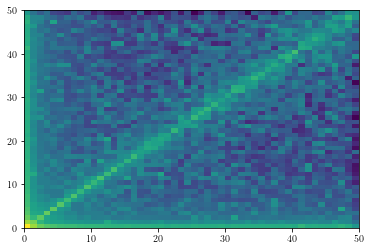

In [552]:
plt.loglog(np.arange(1,n), sfs_xibeta)
plt.loglog(np.arange(1,n), sfs_kingman)
plt.show()



plt.pcolormesh(np.log(twosfs_xibeta))
plt.show()
plt.pcolormesh(np.log(twosfs_kingman))
plt.show()

1


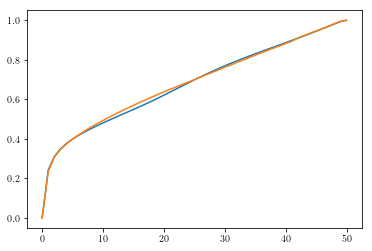

2


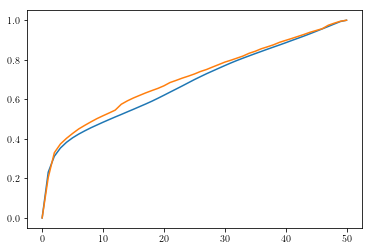

3


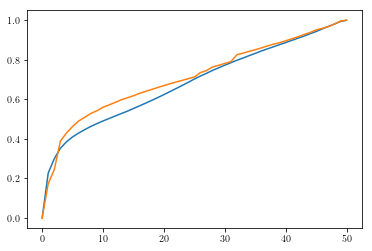

4


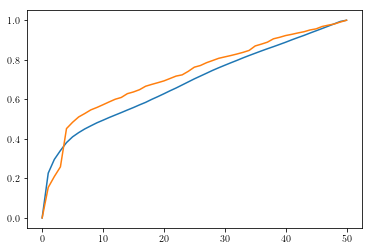

5


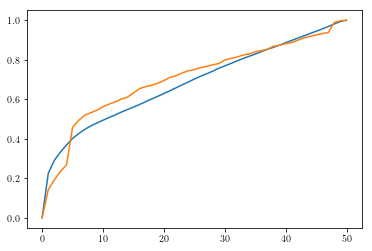

6


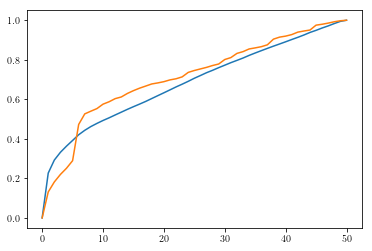

7


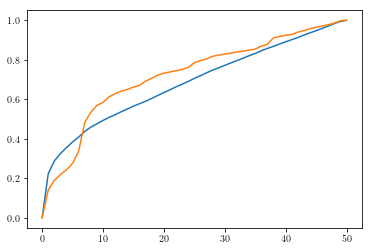

8


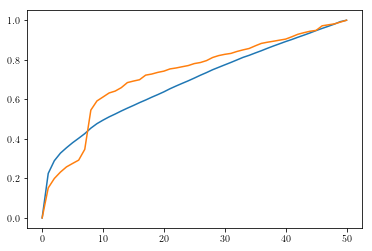

9


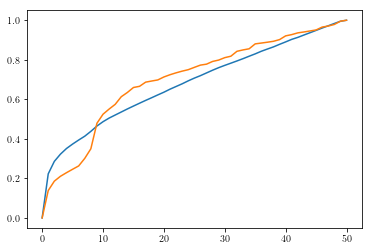

10


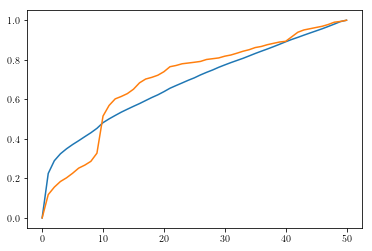

11


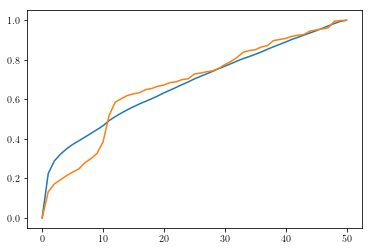

12


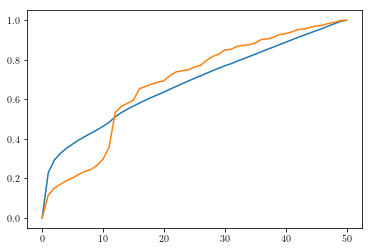

13


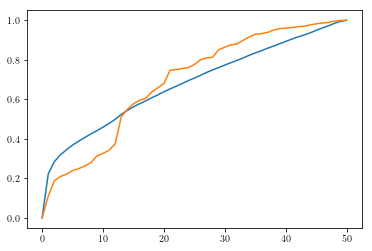

14


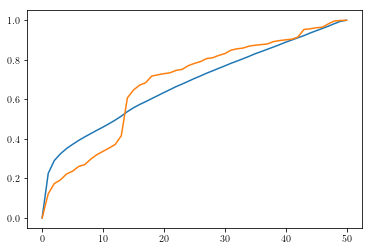

15


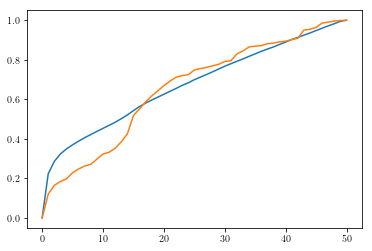

16


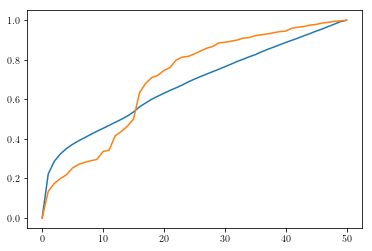

17


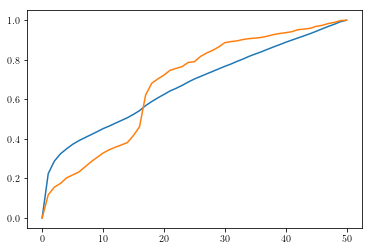

18


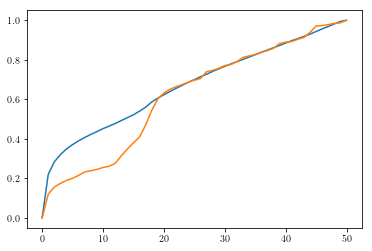

19


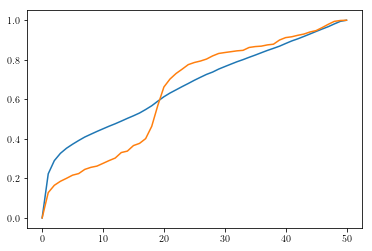

20


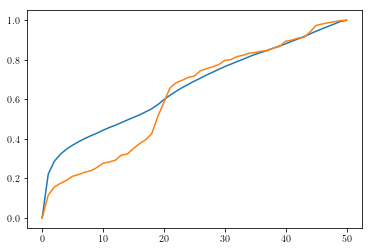

21


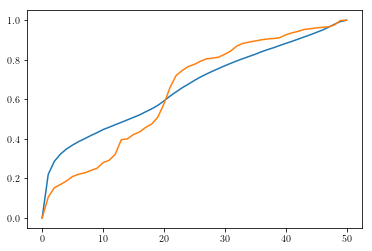

22


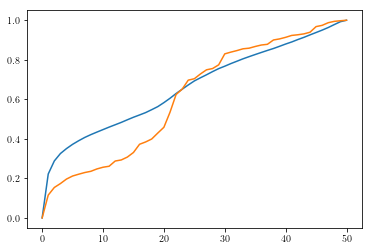

23


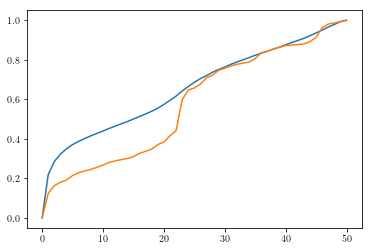

24


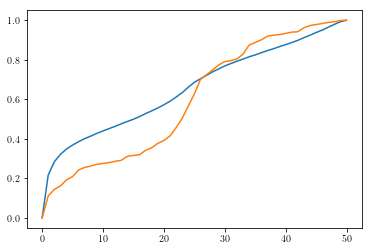

25


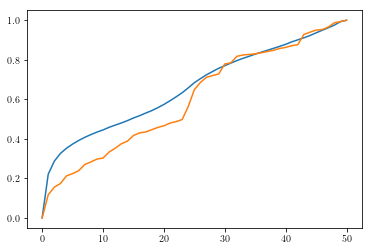

26


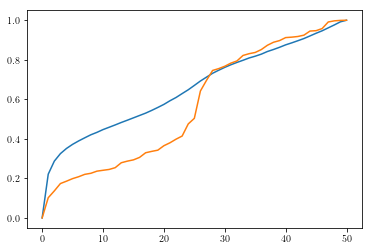

27


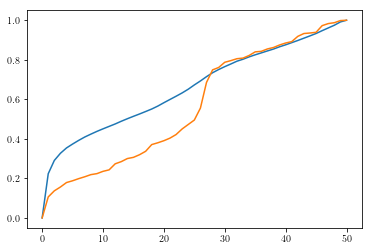

28


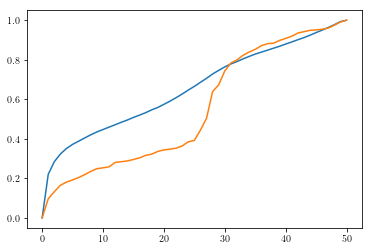

29


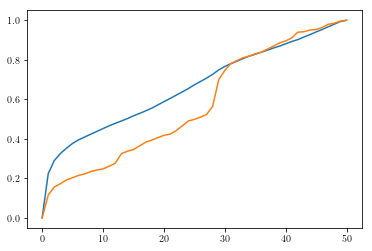

30


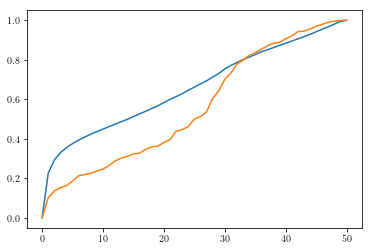

31


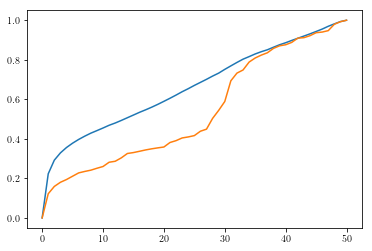

32


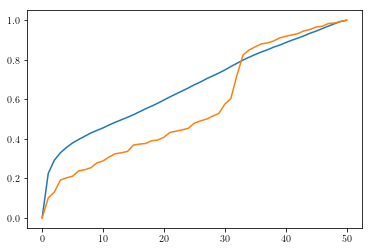

33


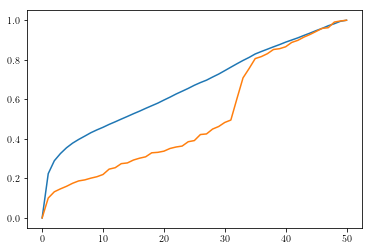

34


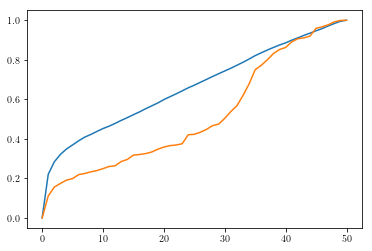

35


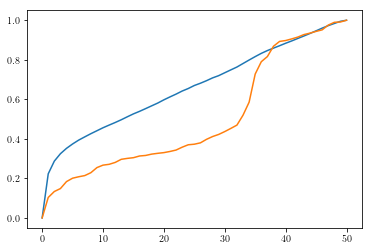

36


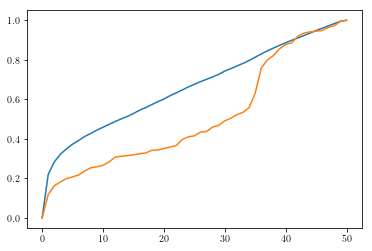

37


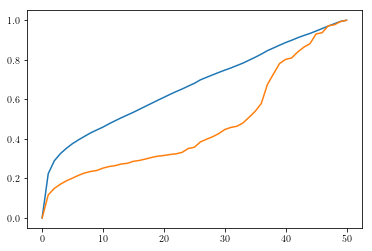

38


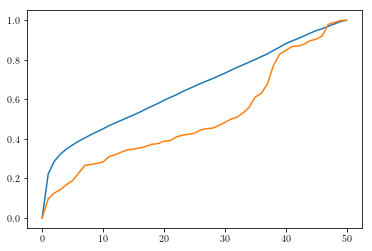

39


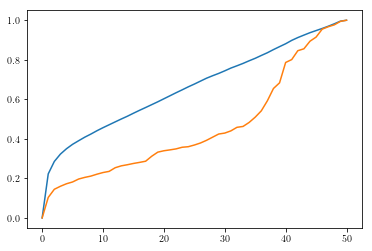

40


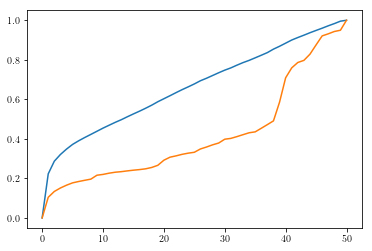

41


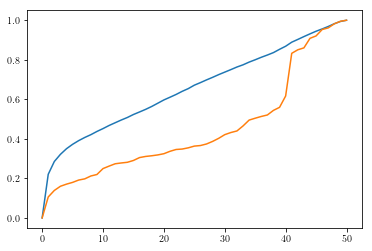

42


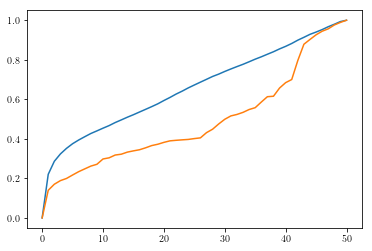

43


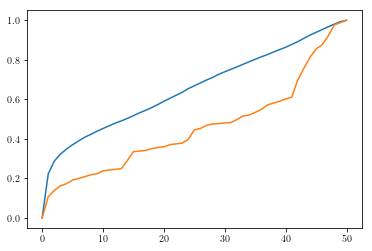

44


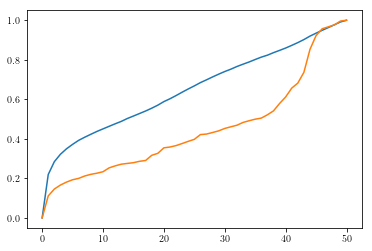

45


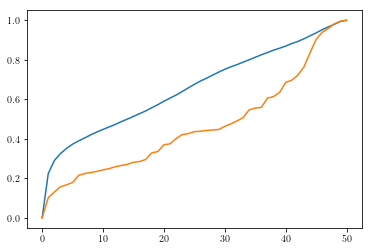

46


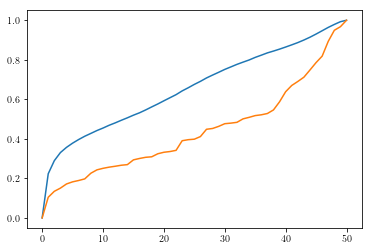

47


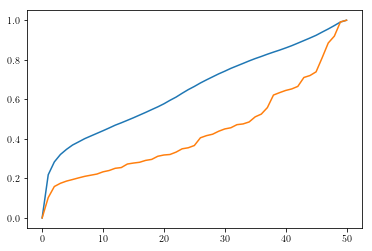

48


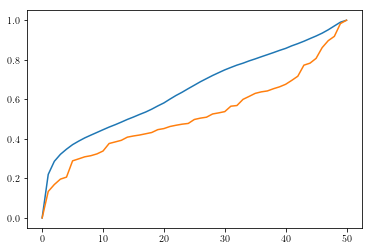

49


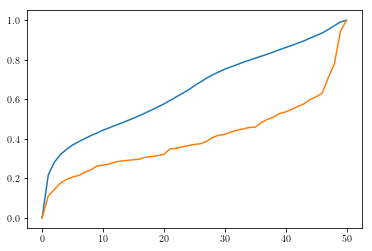

50


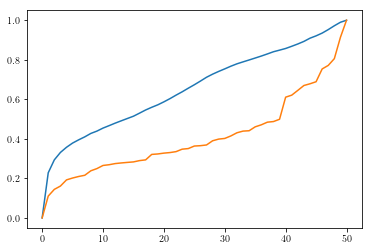

In [480]:
F_xibeta = np.cumsum(twosfs_xibeta, axis=1)
F_xibeta /= F_xibeta[:,-1][:,None]


F_kingman = np.cumsum(twosfs_kingman, axis=1)
F_kingman /= F_kingman[:,-1][:,None]


for i in range(n//2):
    print(i+1)
    x = np.arange(0,n//2+1)
    plt.plot(x, np.hstack([[0], F_xibeta[i]]))
    plt.plot(x, np.hstack([[0], F_kingman[i]]))
    plt.show()

In [536]:
def resample_distance(sampling_dist, comparison_dist, n_obs, n_reps):
    F_exp = np.cumsum(comparison_dist, axis=1)
    F_exp /= F_exp[:,-1][:,None]
    
    D = np.zeros((n_reps, sampling_dist.shape[0]))
    for rep in range(n_reps):
        rand_counts = np.random.multinomial(n_obs, sampling_dist.ravel()).reshape(sampling_dist.shape)
        rand_counts = (rand_counts + rand_counts.T) / 2
        
        cumcounts = np.cumsum(rand_counts, axis=1)
        n_row = cumcounts[:,-1]
        F_obs = cumcounts / n_row[:,None]
        
        D[rep] = np.max(np.abs(F_obs - F_exp), axis=1) * np.sqrt(n_row)

    return D



In [537]:
def violin_with_iqrange(data, color):
    lb = np.percentile(data, 25, axis=0)
    ub = np.percentile(data, 75, axis=0)
    plt.violinplot(data, showextrema=False)
    plt.plot(x, lb, linestyle='', marker='_', color=color)
    plt.plot(x, ub, linestyle='', marker='_', color=color)
    plt.vlines(x, ub, lb, color=color)



In [540]:
print(n_obs_tot)

22613.0


/Users/danielrice/miniconda3/envs/multiplemergers/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/Users/danielrice/miniconda3/envs/multiplemergers/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/danielrice/miniconda3/envs/multiplemergers/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/danielrice/miniconda3/envs/multiplemergers/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/danielrice/miniconda3/envs/multiplemergers/lib/python3.6/site-packages/numpy/linalg/linalg.py:1874: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signatur

Text(0, 0.5, 'CvM statistic, $D$')

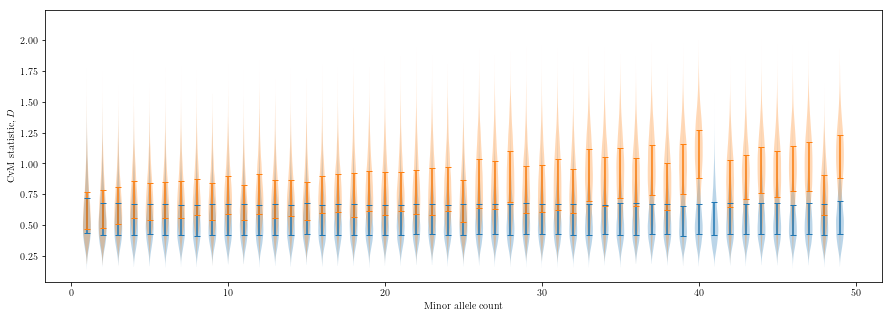

In [554]:
n_resample = 10000
n_pairs = 500
D_kingman = resample_distance(twosfs_kingman, twosfs_kingman, n_pairs, n_resample)
D_xibeta  = resample_distance(twosfs_xibeta, twosfs_kingman, n_pairs, n_resample)


fig = plt.figure(figsize=(15,5))
violin_with_iqrange(D_kingman, 'C0')
violin_with_iqrange(D_xibeta, 'C1')
plt.xlabel("Minor allele count")
plt.ylabel("CvM statistic, $D$")
# plt.ylim([-0.00050,0.0075])

0.23340030843501214
0.06151732429724088
1.0
1.0


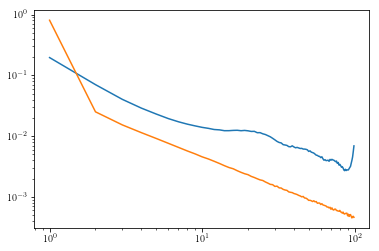

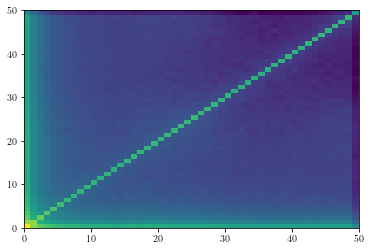

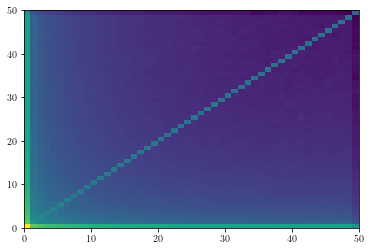

In [550]:
n = 100
alpha = 1.75
model = "2EpochConst"

r_xibeta = "0.0"
r_kingman = "0.0"

xibeta_fn = "../simulations/msprime/jsfs_n-{}_xibeta-{}_r-{}.txt".format(n, alpha, r_xibeta)
kingman_fn = "../simulations/msprime/jsfs_fastNeutrino-xibeta_n-{}_alpha-{}_{}_r-{}.txt".format(n,alpha,model,r_kingman)

sfs_xibeta, twosfs_xibeta, _, _ = readsim(xibeta_fn)
print(h.sfs2pi((sfs_xibeta + sfs_xibeta[::-1])[:n//2],n))
twosfs_xibeta /= np.sum(twosfs_xibeta)
twosfs_xibeta = fold_twosfs(twosfs_xibeta)

sfs_kingman, twosfs_kingman, times, sizes = readsim(kingman_fn)
print(h.sfs2pi((sfs_kingman + sfs_kingman[::-1])[:n//2],n))
twosfs_kingman /= np.sum(twosfs_kingman)
twosfs_kingman = fold_twosfs(twosfs_kingman)

# Check normalization
print(np.sum(twosfs_xibeta))
print(np.sum(twosfs_kingman))

plt.loglog(np.arange(1,n), sfs_xibeta)
plt.loglog(np.arange(1,n), sfs_kingman)
plt.show()


plt.pcolormesh(np.log(twosfs_xibeta))
plt.show()
plt.pcolormesh(np.log(twosfs_kingman))
plt.show()

/Users/danielrice/miniconda3/envs/multiplemergers/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Text(0, 0.5, 'CvM statistic, $D$')

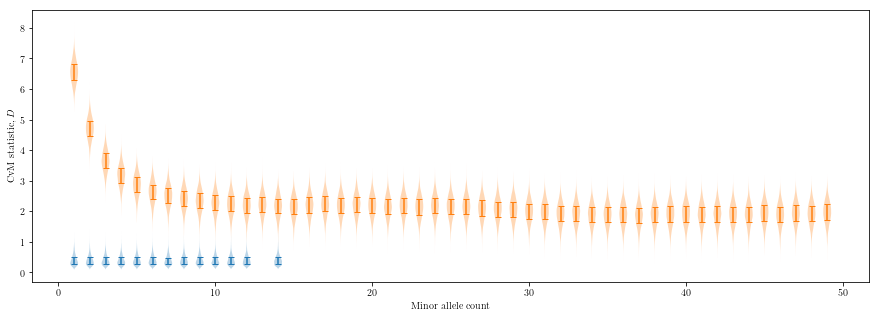

In [545]:
n_resample = 10000
n_pairs = 1000

D_kingman = resample_distance(twosfs_kingman, twosfs_kingman, n_pairs, n_resample)
D_xibeta  = resample_distance(twosfs_xibeta, twosfs_kingman, n_pairs, n_resample)


fig = plt.figure(figsize=(15,5))
violin_with_iqrange(D_kingman, 'C0')
violin_with_iqrange(D_xibeta, 'C1')
plt.xlabel("Minor allele count")
plt.ylabel("CvM statistic, $D$")
# plt.ylim([-0.00050,0.0075])